In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
from functools import reduce
import seaborn as sns

# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [ ]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql import Window
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, lag, lead, avg, count, unix_timestamp
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

MAX_MEMORY = '8G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 60000) \
        .set('spark.network.timeout', 60000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Lab_1_var_5") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

directory_path = "data/"

file_list = [file for file in os.listdir(directory_path) if file.endswith(".csv")]

# Чтение файлов и создание DataFrame с явным указанием разделителя
dataframes = [spark.read.csv(os.path.join(directory_path, file), header=True, inferSchema=True, sep=';') for file in file_list]

# Объединение DataFrame в один
merged_dataframe = reduce(DataFrame.union, dataframes)

# Вывод первых строк объединенного DataFrame
merged_dataframe.limit(5).toPandas().head()

In [3]:
merged_dataframe.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- period_id: integer (nullable = true)
 |-- actual_consumption: double (nullable = true)
 |-- actual_pv: double (nullable = true)
 |-- load_00: double (nullable = true)
 |-- load_01: double (nullable = true)
 |-- load_02: double (nullable = true)
 |-- load_03: double (nullable = true)
 |-- load_04: double (nullable = true)
 |-- load_05: double (nullable = true)
 |-- load_06: double (nullable = true)
 |-- load_07: double (nullable = true)
 |-- load_08: double (nullable = true)
 |-- load_09: double (nullable = true)
 |-- load_10: double (nullable = true)
 |-- load_11: double (nullable = true)
 |-- load_12: double (nullable = true)
 |-- load_13: double (nullable = true)
 |-- load_14: double (nullable = true)
 |-- load_15: double (nullable = true)
 |-- load_16: double (nullable = true)
 |-- load_17: double (nullable = true)
 |-- load_18: double (nullable = true)
 |-- load_19: double (nullable = true

In [4]:
# Вывод количества строк до удаления пустых значений
merged_dataframe.count()

962282

In [5]:
# Удаление строк с пропущенными значениями
cleaned_dataframe = merged_dataframe.dropna()

# Вывод количество строк после удаления пустых значений
merged_dataframe.count()

962282

In [6]:
# Найти строки с пропущенными значениями в любом столбце
na_rows_dataframe = merged_dataframe.filter(reduce(lambda x, y: x | y, (col(c).isNull() for c in merged_dataframe.columns)))

# Вывести часть DataFrame с пропущенными значениями
na_rows_dataframe.count()

0

<Axes: >

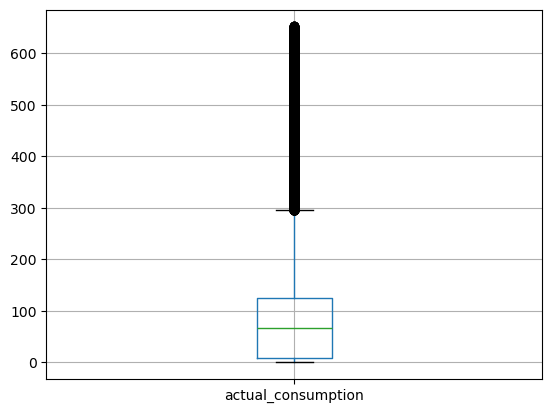

In [7]:
dataframe_pandas = cleaned_dataframe.select('actual_consumption', 'actual_pv').toPandas()

f_other = plt.plot()
dataframe_pandas.boxplot(column=['actual_consumption'], figsize=(10,  10))

In [8]:
# Рассчет квартилей
quartiles = cleaned_dataframe.stat.approxQuantile("actual_consumption", [0.25, 0.75], 0.0)

# Рассчет межквартильного размаха
IQR = quartiles[1] - quartiles[0]

# Определение границ для определения выбросов
lower_bound = quartiles[0] - 1.5 * IQR
upper_bound = quartiles[1] + 1.5 * IQR

# Удаление выбросов
cleaned_dataframe = cleaned_dataframe.filter((col("actual_consumption") >= lower_bound) & (col("actual_consumption") <= upper_bound))
cleaned_dataframe.count()

937250

<Axes: >

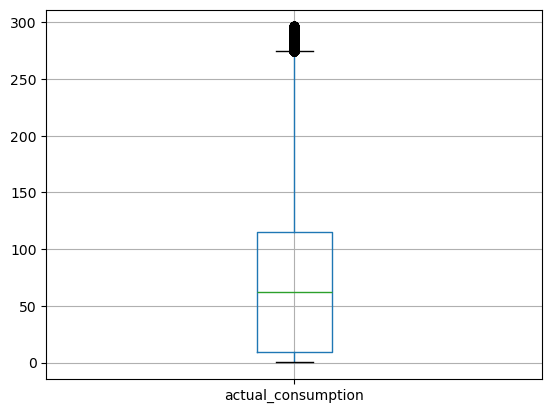

In [9]:
dataframe_pandas = cleaned_dataframe.select('actual_consumption', 'actual_pv').toPandas()

f_other = plt.plot()
dataframe_pandas.boxplot(column=['actual_consumption'], figsize=(10,  10))

In [10]:
# Расчет статистических показателей
statistics_summary = cleaned_dataframe.describe()
# Вывод сводной статистики
statistics_summary.toPandas()

,summary,site_id,period_id,actual_consumption,actual_pv,load_00,load_01,load_02,load_03,load_04,...,pv_86,pv_87,pv_88,pv_89,pv_90,pv_91,pv_92,pv_93,pv_94,pv_95
0,count,937250,937250,937250,937250,937250,937250,937250,937250,937250,...,937250,937250,937250,937250,937250,937250,937250,937250,937250,937250
1,mean,8.346216057615363,43.637392371299015,76.29608426239884,44.22265404242653,76.64541092001288,76.91333041322417,77.16233108586778,77.40472196001014,77.63912441178658,...,44.956692242815095,44.792086910344814,44.63573050176393,44.48199781631874,44.331886713141365,44.186294440527206,44.0461375120001,43.912691389455354,43.78787755408679,43.67510209582759
2,stddev,4.314631433609098,32.05170928236231,72.81053285484741,99.05166827191897,73.24839399793221,73.73646287708942,74.25712465501798,74.79713031488632,75.3742520212786,...,94.2421379065009,93.9910803124323,93.7524599934208,93.5175342015883,93.286799046121,93.06419003088651,92.85731384021553,92.66925262309388,92.49831672898465,92.35360449404604
3,min,1,0,0.14690635762456802,0.0,-263.0548926545911,-246.1912322317578,-233.6445941427881,-218.45698555652248,-213.6772964753053,...,-9.389647857224844,-9.389647857222855,-9.389647857220595,-9.389647857219726,-9.389647857219241,-9.389647857219147,-9.389647857219076,-9.389647857218971,-9.389647857218957,-9.389647857218932
4,max,15,120,296.30518566316505,755.3993506760426,658.4492607170723,681.8835032763551,683.0263756645019,676.1435017729069,682.9575798114286,...,715.7096701768883,715.7096701768833,715.709670176884,715.709670176884,715.7096701768833,715.7096701768835,715.7096701768841,715.7096701768844,715.7096701768845,715.7096701768845


<Figure size 800x600 with 0 Axes>

(array([251833.,  60442.,  59034.,  21034.,  14454.,  49995.,  45228.,
         30051.,  50360.,  56441.,  43107.,  29400.,  19232.,  19397.,
         19208.,  19881.,  18260.,  17622.,  14902.,  15445.,  15411.,
         12297.,  11756.,  10923.,   8054.,   5887.,   5197.,   4503.,
          4645.,   3251.]),
 array([1.46906358e-01, 1.00188490e+01, 1.98907916e+01, 2.97627343e+01,
        3.96346769e+01, 4.95066196e+01, 5.93785622e+01, 6.92505049e+01,
        7.91224475e+01, 8.89943901e+01, 9.88663328e+01, 1.08738275e+02,
        1.18610218e+02, 1.28482161e+02, 1.38354103e+02, 1.48226046e+02,
        1.58097989e+02, 1.67969931e+02, 1.77841874e+02, 1.87713817e+02,
        1.97585759e+02, 2.07457702e+02, 2.17329645e+02, 2.27201587e+02,
        2.37073530e+02, 2.46945472e+02, 2.56817415e+02, 2.66689358e+02,
        2.76561300e+02, 2.86433243e+02, 2.96305186e+02]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Distribution of actual_consumption')

Text(0.5, 0, 'actual_consumption')

Text(0, 0.5, 'Frequency')

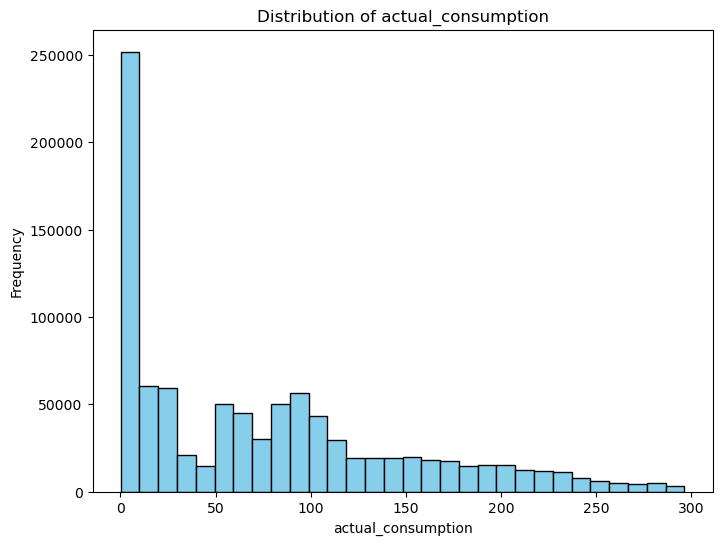

<Figure size 800x600 with 0 Axes>

(array([6.83836e+05, 6.35140e+04, 2.91590e+04, 2.65580e+04, 1.90620e+04,
        1.41880e+04, 1.29630e+04, 1.32210e+04, 1.26780e+04, 1.11010e+04,
        8.38200e+03, 6.47900e+03, 5.63800e+03, 4.72400e+03, 4.10400e+03,
        3.30500e+03, 2.82100e+03, 2.41100e+03, 2.25800e+03, 2.19400e+03,
        2.18200e+03, 1.86900e+03, 1.59000e+03, 1.17800e+03, 7.79000e+02,
        5.01000e+02, 3.32000e+02, 1.51000e+02, 6.30000e+01, 9.00000e+00]),
 array([  0.        ,  25.17997836,  50.35995671,  75.53993507,
        100.71991342, 125.89989178, 151.07987014, 176.25984849,
        201.43982685, 226.6198052 , 251.79978356, 276.97976191,
        302.15974027, 327.33971863, 352.51969698, 377.69967534,
        402.87965369, 428.05963205, 453.23961041, 478.41958876,
        503.59956712, 528.77954547, 553.95952383, 579.13950218,
        604.31948054, 629.4994589 , 654.67943725, 679.85941561,
        705.03939396, 730.21937232, 755.39935068]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Distribution of actual_pv')

Text(0.5, 0, 'actual_pv')

Text(0, 0.5, 'Frequency')

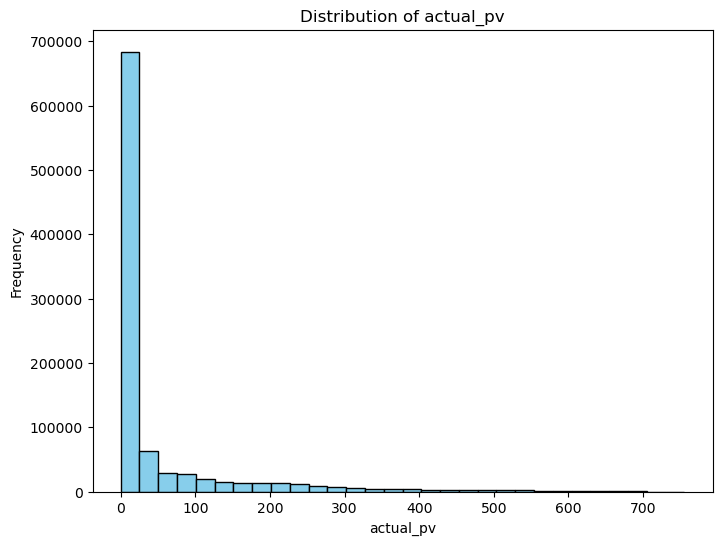

In [11]:
# Выберите признаки, для которых вы хотите построить распределение
selected_features = ['actual_consumption', 'actual_pv'] 

# Преобразование PySpark DataFrame в Pandas DataFrame
pandas_df = cleaned_dataframe.select(selected_features).toPandas()

# Построение гистограмм для каждого выбранного признака
for feature in selected_features:
    plt.figure(figsize=(8, 6))
    plt.hist(pandas_df[feature], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

In [12]:
# Преобразование столбца timestamp в метку времени Unix
correlation_dataframe = cleaned_dataframe.withColumn("timestamp", unix_timestamp("timestamp").cast(DoubleType()))

# Создаем VectorAssembler для объединения признаков в один вектор
feature_cols = ['timestamp', 'site_id', 'period_id', 'actual_consumption', 'actual_pv']  
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Применяем VectorAssembler к данным
data = vector_assembler.transform(correlation_dataframe)

# Вычисляем матрицу корреляции
correlation_matrix = Correlation.corr(data, "features").head()
correlation_array = correlation_matrix[0].toArray()

# Создаем DataFrame из матрицы корреляции
correlation_df = spark.createDataFrame(correlation_array.tolist(), feature_cols)

# Выводим матрицу корреляции
correlation_df.toPandas().head()

,timestamp,site_id,period_id,actual_consumption,actual_pv
0,1.000000,-0.073418,0.612583,0.118632,0.062304
1,-0.073418,1.000000,0.195226,0.097531,0.100411
2,0.612583,0.195226,1.000000,0.173963,0.093939
3,0.118632,0.097531,0.173963,1.000000,0.419026
4,0.062304,0.100411,0.093939,0.419026,1.000000


<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Матрица корреляции признаков')

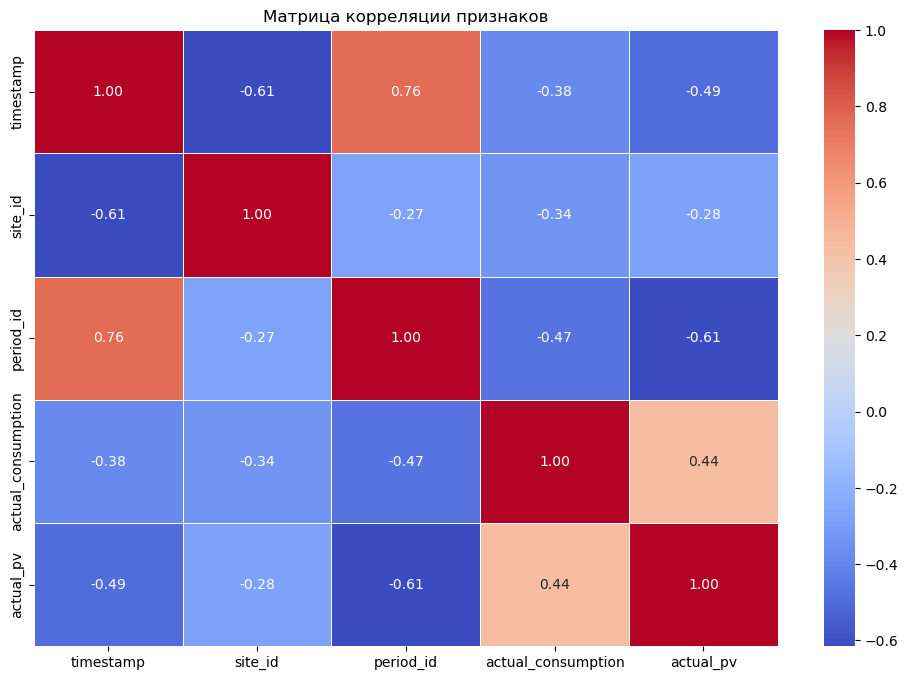

In [13]:
# Строим тепловую карту корреляции с использованием Seaborn
correlation_matrix = correlation_df.toPandas().corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Матрица корреляции признаков')
plt.show()

In [14]:
# Определяем окно сортировки по полю 'timestamp'
windowSpec = Window.orderBy(desc("timestamp"))

# Добавляем столбцы с лагами и лидами для 'load_00'
data_with_lag_lead = cleaned_dataframe.withColumn("lag_load_00", lag("load_00").over(windowSpec)) \
                            .withColumn("lead_load_00", lead("load_00").over(windowSpec))

# Группируем данные по 'timestamp' и аггрегируем с использованием desc сортировки
last_three_timestamps = data_with_lag_lead.groupBy("timestamp") \
                                          .agg(count("timestamp").alias("count")) \
                                          .orderBy(desc("timestamp")) \
                                          .limit(3)

# Присоединяем последние три метки времени к данным
latest_rows = data_with_lag_lead.join(last_three_timestamps, "timestamp")

result = latest_rows.withColumn("avg_load_00", (col("lag_load_00") + col("lead_load_00") + col("load_00")) / 3) \
                          .select("timestamp", "load_00", "lag_load_00", "lead_load_00", "avg_load_00")

# Выводим результат
result.show()

+-------------------+------------------+------------------+------------------+------------------+
|          timestamp|           load_00|       lag_load_00|      lead_load_00|       avg_load_00|
+-------------------+------------------+------------------+------------------+------------------+
|2017-10-21 23:45:00|  54.4986152487534|              NULL|25.772150237220846|              NULL|
|2017-10-21 23:45:00|25.772150237220846|  54.4986152487534| 9.485006903820448|29.918590796598235|
|2017-10-21 23:45:00| 9.485006903820448|25.772150237220846| 6.224997008085698|13.827384716375663|
|2017-10-21 23:45:00| 6.224997008085698| 9.485006903820448| 54.11337219438211|23.274458702096084|
|2017-10-21 23:30:00| 54.11337219438211| 6.224997008085698|25.504997606821835| 28.61445560309655|
|2017-10-21 23:30:00|25.504997606821835| 54.11337219438211| 9.152194249568677|29.590188016924206|
|2017-10-21 23:30:00| 9.152194249568677|25.504997606821835| 5.610520245340206|13.422570700576907|
|2017-10-21 23:30:00

In [19]:
# Сохраним преобразованный датафрейм в csv-файл.
cleaned_dataframe.coalesce(1).write.options(header='True', delimiter=';').csv('filtered_data/data')

# Закрываем сессию Spark
spark.stop()